# Examine

## Imports and Globals

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import time

from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

In [2]:
# Globals
SEED = 22
start_time = time.time()

## Load data

In [3]:
data_dir = Path("../data/cleaned")
years = [2019, 2020, 2021, 2022, 2023]

dfs = []
for year in years:
    file = data_dir / f"brfss_cleaned_{year}.csv"
    print(f"Loading {file}")
    df = pd.read_csv(file)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Merged shape: {df_all.shape}")
df.head()

Loading ../data/cleaned/brfss_cleaned_2019.csv


/tmp/ipykernel_3910327/2246757359.py:8: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loading ../data/cleaned/brfss_cleaned_2020.csv
Loading ../data/cleaned/brfss_cleaned_2021.csv
Loading ../data/cleaned/brfss_cleaned_2022.csv
Loading ../data/cleaned/brfss_cleaned_2023.csv
Merged shape: (2132659, 14)


,year,age,sex,educa,bmi,bmi_cat,drink_any,snap_used,food_insecurity,smoke_100,exercise_any,diabetes
0,2023,85.0,Female,Some college,30.47,Obese,No,No,Never,No,No,Yes
1,2023,85.0,Female,Some college,28.56,Overweight,No,No,Never,No,Yes,No
2,2023,85.0,Female,HS or GED,22.31,Normal,No,No,Never,Yes,Yes,No
3,2023,77.0,Female,Some college,27.44,Overweight,No,No,Never,No,Yes,No
4,2023,77.0,Female,Some college,25.85,Overweight,Yes,No,Rarely,No,Yes,Yes


## Quick EDA

In [4]:
# Check target class balance
print(df_all["diabetes"].value_counts())
print(df_all["diabetes"].value_counts(normalize=True))

diabetes
No     1826551
Yes     306108
Name: count, dtype: int64
diabetes
No     0.856467
Yes    0.143533
Name: proportion, dtype: float64


In [5]:
# Count by year
print(df_all.groupby("year")["diabetes"].value_counts(normalize=True))

year  diabetes
2019  No          0.853427
      Yes         0.146573
2020  No          0.861725
      Yes         0.138275
2021  No          0.859669
      Yes         0.140331
2022  No          0.853632
      Yes         0.146368
2023  No          0.854191
      Yes         0.145809
Name: proportion, dtype: float64


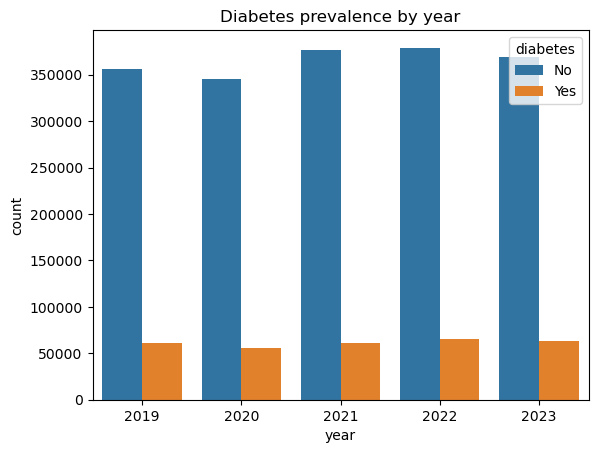

In [6]:
sns.countplot(data=df_all, x="year", hue="diabetes")
plt.title("Diabetes prevalence by year")
plt.show()

## Baseline model

### Preprocessing

In [7]:
df_model = df_all.copy()

# Just include features common to all years
common_features = ["age", "sex", "educa", "bmi", "bmi_cat", "smoke_100", "exercise_any"]

df_common = df_model.dropna(subset=common_features + ["diabetes"])
df_common = df_common[common_features + ["diabetes"]].copy()

### Convert binary and categorical vars
binary_cols = ["smoke_100", "exercise_any", "diabetes"]
for col in binary_cols:
    df_common[col] = (
        df_common[col]
        .astype(str)
        .str.strip()
        .str.replace('"', "")
        .map({"Yes": 1, "No": 0})
    )

In [8]:
### Convert categorical strings to dummy vars
df_common = pd.get_dummies(
    df_common, columns=["sex", "educa", "bmi_cat"], drop_first=True
)
df_common.head()
# print(df_common.columns.tolist())
# print("Any NaNs in X?", df_common.drop(columns=["diabetes"]).isna().any().any())

,age,bmi,smoke_100,exercise_any,diabetes,sex_Male,educa_HS or GED,educa_Less than HS,educa_Some college,bmi_cat_Obese,bmi_cat_Overweight,bmi_cat_Underweight
0,85.0,28.17,1,0,0,False,False,True,False,False,True,False
1,72.0,18.54,0,1,0,False,False,False,True,False,False,False
2,67.0,31.62,0,1,1,False,False,False,False,True,False,False
4,85.0,21.48,1,0,0,False,False,False,True,False,False,False
6,72.0,32.98,1,1,1,True,False,False,False,True,False,False


In [9]:
# Split features and target
X = df_common.drop(columns=["diabetes"])
y = df_common["diabetes"]

## Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

## Baseline Model

In [11]:
# model = LogisticRegression(max_iter=1000, class_weight="balanced")
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

## Evaluation

### Precision-Recall Curve

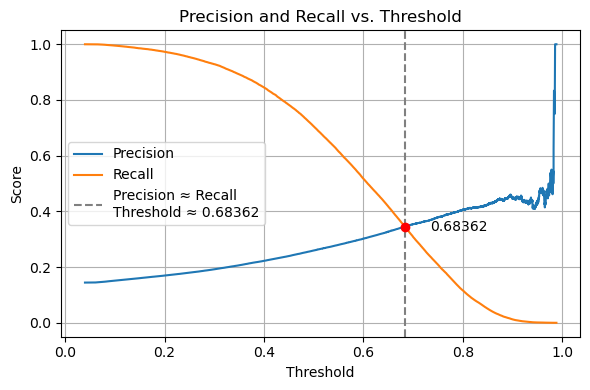

In [13]:
y_probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate where precision and recall are closest
pr_diff = np.abs(precision[:-1] - recall[:-1])
cross_idx = np.argmin(pr_diff)
cross_threshold = thresholds[cross_idx]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(
    cross_threshold,
    linestyle="--",
    color="gray",
    label=f"Precision ≈ Recall\nThreshold ≈ {cross_threshold:.5f}",
)
plt.scatter([cross_threshold], [precision[cross_idx]], color="red", zorder=5)

# Annotate the crossover point
plt.text(
    cross_threshold + 0.05,
    precision[cross_idx],
    f"{cross_threshold:.5f}",
    color="black",
    fontsize=10,
    va="center",
)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../reports/logistic_threshold_crosspoint.png")
plt.show()

### Classification Report

In [14]:
y_pred_thresh = (y_probs >= cross_threshold).astype(int)
print(f"\nLogistic Regression Classification Report (threshold = {cross_threshold:.5f})")
print(classification_report(y_test, y_pred_thresh))


Logistic Regression Classification Report (threshold = 0.68362)
              precision    recall  f1-score   support

           0       0.89      0.89      0.89    315358
           1       0.35      0.35      0.35     53222

    accuracy                           0.81    368580
   macro avg       0.62      0.62      0.62    368580
weighted avg       0.81      0.81      0.81    368580



### Confusion Matrix

<Figure size 600x400 with 0 Axes>

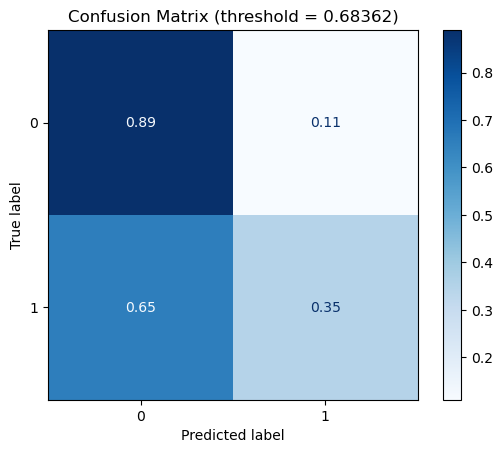

In [15]:
y_pred_thresh = (y_probs >= cross_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_thresh, normalize="true")
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format=".2f")
plt.title(f"Confusion Matrix (threshold = {cross_threshold:.5f})")
plt.grid(False)
plt.savefig("../reports/logistic_confusion_matrix.png")
plt.show();

In [16]:
beta = 2  # recall emphasis
f2_scores = (1 + beta**2) * (precision[:-1] * recall[:-1]) / (beta**2 * precision[:-1] + recall[:-1] + 1e-8)
f2_idx = np.argmax(f2_scores)
f2_threshold = thresholds[f2_idx]
print(f"Best F2 threshold: {f2_threshold:.5f}")


Best F2 threshold: 0.40549


In [17]:
beta = 0.5  # precision emphasis
f05_scores = (1 + beta**2) * (precision[:-1] * recall[:-1]) / (beta**2 * precision[:-1] + recall[:-1] + 1e-8)
f05_idx = np.argmax(f05_scores)
f05_threshold = thresholds[f05_idx]
print(f"Best F0.5 threshold: {f05_threshold:.5f}")


Best F0.5 threshold: 0.68551


In [18]:
from sklearn.metrics import classification_report

print("\nF2-optimized classification report:")
print(classification_report(y_test, y_probs >= f2_threshold))

print("\nF0.5-optimized classification report:")
print(classification_report(y_test, y_probs >= f05_threshold))



F2-optimized classification report:
              precision    recall  f1-score   support

           0       0.95      0.51      0.66    315358
           1       0.22      0.84      0.35     53222

    accuracy                           0.56    368580
   macro avg       0.59      0.67      0.51    368580
weighted avg       0.84      0.56      0.62    368580


F0.5-optimized classification report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89    315358
           1       0.35      0.34      0.34     53222

    accuracy                           0.81    368580
   macro avg       0.62      0.62      0.62    368580
weighted avg       0.81      0.81      0.81    368580



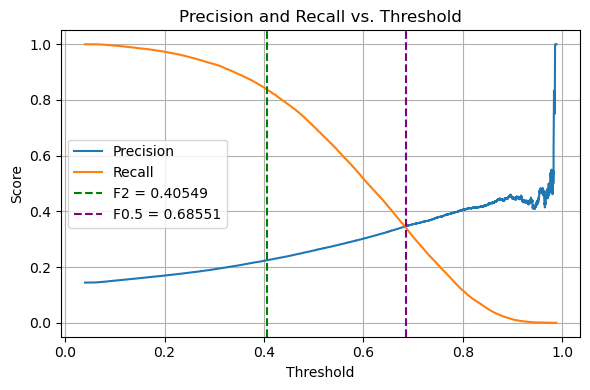

In [19]:
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

plt.axvline(f2_threshold, color="green", linestyle="--", label=f"F2 = {f2_threshold:.5f}")
plt.axvline(f05_threshold, color="purple", linestyle="--", label=f"F0.5 = {f05_threshold:.5f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


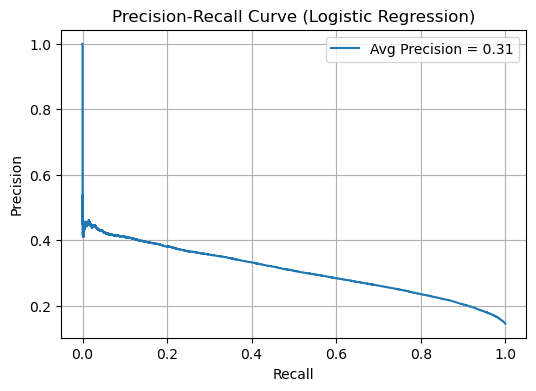

In [20]:
y_probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"Avg Precision = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Logistic Regression)")
plt.legend()
plt.grid(True)
#plt.savefig("../reports/logistic_precision_recall_curve.png")
plt.show()

#### Confusion Matrix

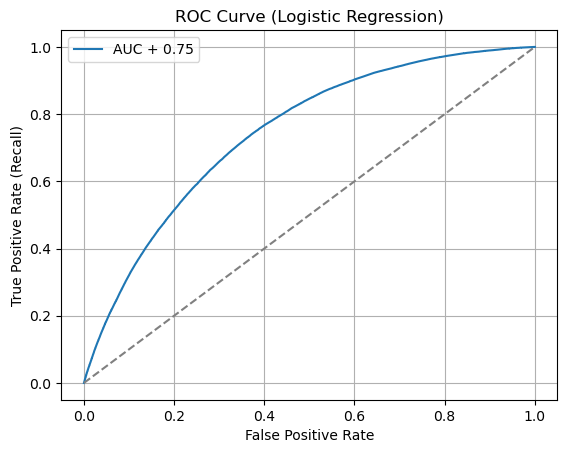

In [21]:
y_probs = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC + {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

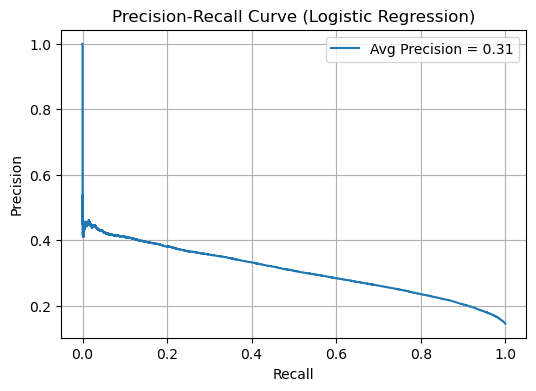

In [22]:
# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"Avg Precision = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Threshold tuning table
threshold_data = pd.DataFrame(
    {"threshold": thresholds_pr, "precision": precision[:-1], "recall": recall[:-1]}
)

threshold_data.head(20)

,threshold,precision,recall
0,0.039993,0.144397,1.0
1,0.041441,0.144398,1.0
2,0.041967,0.144398,1.0
3,0.043335,0.144399,1.0
4,0.043759,0.144399,1.0
5,0.044097,0.144399,1.0
6,0.044426,0.144400,1.0
7,0.044993,0.144400,1.0
8,0.045194,0.144401,1.0
9,0.045272,0.144401,1.0


In [24]:
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_probs)

threshold_data = pd.DataFrame(
    {
        "threshold": thresholds_pr,
        "precision": precision_vals[:-1],
        "recall": recall_vals[:-1],
    }
)

# Filter to better tradeoffs
threshold_data_filtered = threshold_data[
    (threshold_data["precision"] > 0.3) & (threshold_data["recall"] > 0.4)
].reset_index(drop=True)

threshold_data_filtered.head(20)

,threshold,precision,recall
0,0.595888,0.300001,0.526267
1,0.595893,0.300004,0.526267
2,0.595904,0.300033,0.526155
3,0.595905,0.300036,0.526155
4,0.595909,0.300038,0.526117
5,0.595910,0.300040,0.526098
6,0.595913,0.300045,0.526079
7,0.595915,0.300041,0.526061
8,0.595926,0.300047,0.526061
9,0.595945,0.300050,0.526061


              precision    recall  f1-score   support

           0       0.91      0.79      0.84    315358
           1       0.30      0.53      0.38     53222

    accuracy                           0.75    368580
   macro avg       0.60      0.66      0.61    368580
weighted avg       0.82      0.75      0.78    368580



<Figure size 500x400 with 0 Axes>

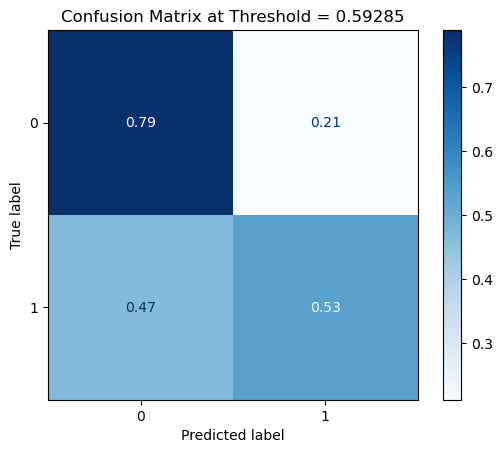

In [25]:
threshold = 0.59285
y_pred_thresh = (y_probs >= threshold).astype(int)

print(classification_report(y_test, y_pred_thresh))

# Show confusion matrix
cm = confusion_matrix(y_test, y_pred_thresh, normalize="true")
plt.figure(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format=".2f")
plt.title(f"Confusion Matrix at Threshold = {threshold:.5f}")
plt.grid(False)
#plt.savefig("../reports/logistic_confusion_matrix.png")
plt.show()

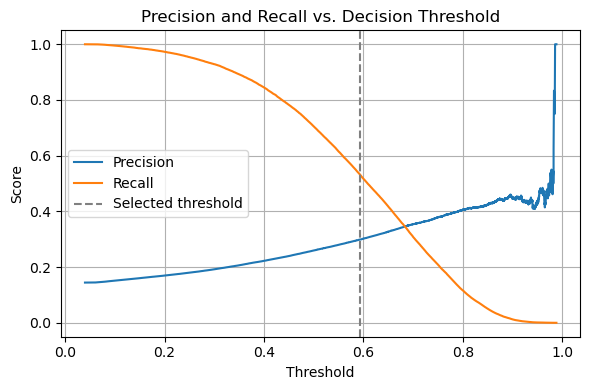

In [26]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# thresholds has one fewer element than precision and recall
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(0.59285, color="gray", linestyle="--", label="Selected threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Decision Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("../reports/logistic_threshold_sweep.png")
plt.show()

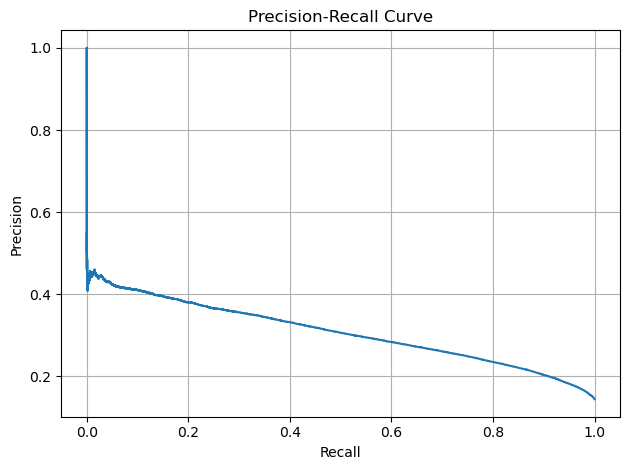

              precision    recall  f1-score   support

           0       0.91      0.79      0.84    315358
           1       0.30      0.53      0.38     53222

    accuracy                           0.75    368580
   macro avg       0.60      0.66      0.61    368580
weighted avg       0.82      0.75      0.78    368580



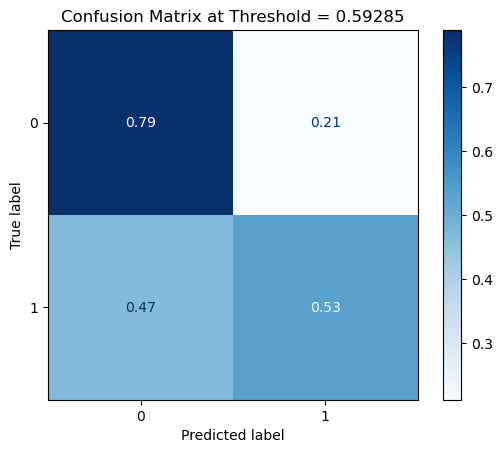

In [27]:
# Step 1: Show PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure()
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.tight_layout()
#plt.savefig("../reports/logistic_precision_recall.png")
plt.show()

# Step 2: Pick threshold based on curve
threshold = 0.59285  # Based on inspection of PR curve
y_pred_thresh = (y_probs >= threshold).astype(int)

# Step 3: Evaluate
print(classification_report(y_test, y_pred_thresh))

cm = confusion_matrix(y_test, y_pred_thresh, normalize="true")
ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format=".2f")
plt.title(f"Confusion Matrix at Threshold = {threshold:.5f}")
plt.grid(False)
#plt.savefig("../reports/logistic_confusion_matrix.png")
plt.show()

In [28]:
from sklearn.metrics import precision_recall_curve

# Get precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Compute F1 manually (vectorized)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold by F1: {best_threshold:.5f}")

Best threshold by F1: 0.56900


In [29]:
import numpy as np

# Find index where precision and recall are closest
pr_diff = np.abs(precision[:-1] - recall[:-1])
best_idx = np.argmin(pr_diff)
best_threshold = thresholds[best_idx]

print(f"Precision and Recall cross at threshold ≈ {best_threshold:.5f}")

Precision and Recall cross at threshold ≈ 0.68362


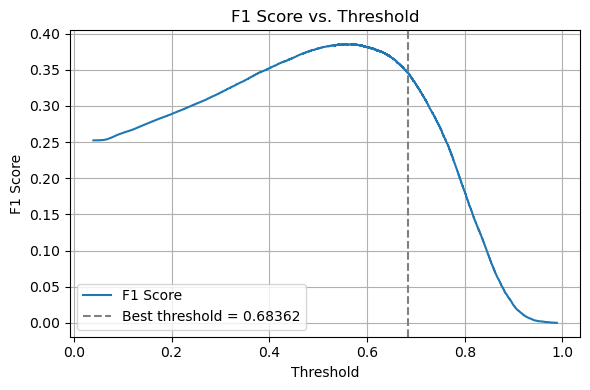

In [30]:
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.axvline(
    best_threshold,
    linestyle="--",
    color="gray",
    label=f"Best threshold = {best_threshold:.5f}",
)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
#plt.savefig("../reports/logistic_f1_threshold.png")
plt.show()

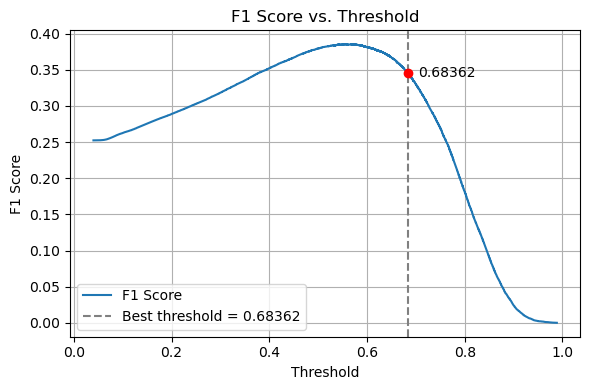

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, label="F1 Score")

# Mark best point
plt.axvline(
    best_threshold,
    linestyle="--",
    color="gray",
    label=f"Best threshold = {best_threshold:.5f}",
)
plt.scatter([best_threshold], [f1_scores[best_idx]], color="red", zorder=5)

# Annotate with text
plt.text(
    best_threshold + 0.02,
    f1_scores[best_idx],
    f"{best_threshold:.5f}",
    color="black",
    fontsize=10,
    va="center",
)

# Labels and formatting
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
#plt.savefig("../reports/logistic_f1_threshold_labeled.png")
plt.show()

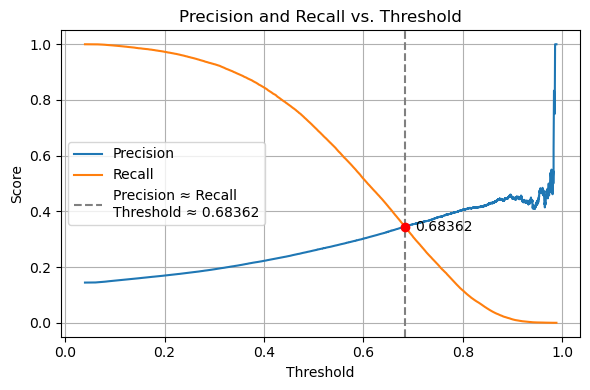

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Already computed:
# precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate where precision and recall are closest
pr_diff = np.abs(precision[:-1] - recall[:-1])
cross_idx = np.argmin(pr_diff)
cross_threshold = thresholds[cross_idx]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(
    cross_threshold,
    linestyle="--",
    color="gray",
    label=f"Precision ≈ Recall\nThreshold ≈ {cross_threshold:.5f}",
)
plt.scatter([cross_threshold], [precision[cross_idx]], color="red", zorder=5)

# Optional annotation
plt.text(
    cross_threshold + 0.02,
    precision[cross_idx],
    f"{cross_threshold:.5f}",
    color="black",
    fontsize=10,
    va="center",
)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
#plt.savefig("../reports/logistic_threshold_crosspoint.png")
plt.show()

## End

In [33]:
time_spent = (time.time() - start_time) / 60

print(f"Notebook time: {time_spent:.2f} minutes")

Notebook time: 1.46 minutes
